In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from ptflops import get_model_complexity_info

import torch
import torch.nn as nn
import torch.nn.functional as F
# torch.multiprocessing.set_start_method('spawn')

import torchvision
from torchvision.transforms import ToTensor, ToPILImage
from torchvision import transforms

import torch_lr_finder
import timm

import cv2

from icecream import ic

from tqdm.notebook import tqdm

In [3]:
path = untar_data(URLs.IMAGENETTE_160)

In [32]:
# dls = ImageDataLoaders.from_folder(path, valid='val', 
#     item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))

dls = ImageDataLoaders.from_folder(path, valid='val', 
    item_tfms=Resize(128, method=ResizeMethod.Squish), batch_tfms=Normalize.from_stats(*imagenet_stats))

In [5]:
[x.shape for x in next(iter(dls[1]))]

[torch.Size([64, 3, 128, 128]), torch.Size([64])]

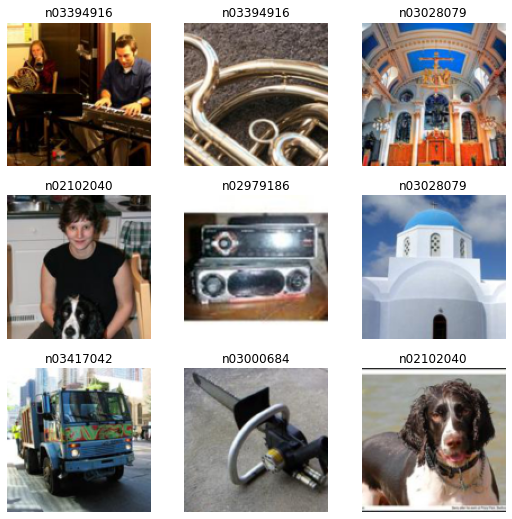

In [6]:
dls.show_batch()

In [7]:
class MyResNetBlock (nn.Module):
    def __init__(self, in_features, out_features, first_stride=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, stride=first_stride, padding=3//2, bias=False),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size=3, stride=1, padding=3//2, bias=False),
            nn.BatchNorm2d(out_features),
        )

        self.downsample_x = None
        if first_stride != 1 or out_features != in_features:
            self.downsample_x = nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=1, stride=first_stride),
                nn.BatchNorm2d(out_features)
            )
    
    def forward(self, x):
        x_adjusted = x if self.downsample_x is None else self.downsample_x(x)
        y = self.block(x)
        return x_adjusted + y

class MyResNet (nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=7//2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=3//2),
        )

        self.conv2 = nn.Sequential(
            MyResNetBlock(64, 64),
            MyResNetBlock(64, 64),
        )

        self.conv3 = nn.Sequential(
            MyResNetBlock(64, 128, first_stride=2),
            MyResNetBlock(128, 128),
        )

        self.conv4 = nn.Sequential(
            MyResNetBlock(128, 256, first_stride=2),
            MyResNetBlock(256, 256),
        )

        self.conv5 = nn.Sequential(
            MyResNetBlock(256, 512, first_stride=2),
            MyResNetBlock(512, 512),
        )

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 10),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        y = self.fc(x)
        # Output size is N, 10
        return y


In [8]:
def custom_learn():
    learn = Learner(dls, MyResNet(), metrics=accuracy)
    # display(get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False))
    # learn.lr_find()
    learn.fit_one_cycle(5, 5e-3)
# custom_learn()

In [9]:
def fastai_learn():
    learn = cnn_learner(dls, resnet18, metrics=accuracy, pretrained=False)
    # get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False)
    learn.fit_one_cycle(5, 5e-3)
# fastai_learn()

In [10]:
def timm_learn():
    m = timm.create_model('resnet18', pretrained=False, num_classes=10)
    learn = Learner(dls, m, metrics=accuracy)
    # get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False)
    learn.fit_one_cycle(5, 5e-3)
#timm_learn()

In [11]:
def timm_learn_pretrained():
    m = timm.create_model('resnet18', pretrained=True, num_classes=10)
    # Freeze everything
    for p in m.parameters():
        p.requires_grad = False
    # Unfreeze the fc layer.
    for p in m.fc.parameters():
        p.requires_grad = True
    learn = Learner(dls, m, metrics=accuracy)
    # get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False)
    learn.fit_one_cycle(5, 5e-3)
#timm_learn_pretrained()

In [25]:
def swap_rb(im):
    return im[:,:,[2,1,0]]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def denormalized_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class ImageNetteDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = [p.name for p in filter(lambda p: p.is_dir(), Path(root_dir).glob('*'))]
        self.classes = sorted(self.classes)
        self.classes_dict = dict(zip(self.classes, range(0, len(self.classes))))

        jpeg_files = list(Path(root_dir).glob('**/*.JPEG'))
        files_class = [self.classes_dict[f.parent.name] for f in jpeg_files]
        self.jpeg_files_and_class = list(zip(jpeg_files, files_class))
        self.num_files = len(self.jpeg_files_and_class)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: x.to(device)),
            # Normalize as if it was a uniform distribution
            # RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))
            transforms.Resize((128,128)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            # transforms.RandomResizedCrop(128, scale=(0.35, 1.0)),
        ])

        # No need for normalization, it expects the class index.
        self.target_transform = transforms.Compose([
            # transforms.ToTensor(),
            # transforms.Lambda(lambda x: x.to(device)),
        ])

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        jpeg_file, target = self.jpeg_files_and_class[idx]
        img = cv2.imread(str(jpeg_file), cv2.IMREAD_COLOR)
        img = swap_rb(img)
        if self.transform:
            img = self.transform(img)
        target = torch.tensor(target)
        return img, self.target_transform(target)

# def pytorch_custom_training():

train_dataset = ImageNetteDataset(Path(path) / 'train')
val_dataset = ImageNetteDataset(Path(path) / 'val')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
# b = next(iter(train_dataloader))
# denormalized_imshow(b[0][0])

EPOCHS = 2

net = MyResNet()
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
# optimizer = torch.optim.SGD(net.parameters(), lr=5e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# lr_finder = torch_lr_finder.LRFinder(net, optimizer, criterion, device=device)
# lr_finder.range_test(train_dataloader, start_lr=1e-5, end_lr=1.0, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3, steps_per_epoch=len(train_dataloader), epochs=EPOCHS)

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    net.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader, leave=False):
        inputs, targets = (batch[0].to(device), batch[1].to(device))
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    train_loss /= len(train_dataloader)
            
    num_correct = 0
    val_loss = 0.0
    num_val_images = 0
    net.eval()
    average_accuracy = 0.0
    with torch.no_grad():        
        for batch in val_dataloader:
            num_val_images += batch[0].shape[0]
            inputs, targets = (batch[0].to(device), batch[1].to(device))
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            predicted_classes = torch.argmax(outputs, dim=1)
            num_correct += torch.count_nonzero(predicted_classes == targets).item()
            average_accuracy += (predicted_classes == targets).float().mean()
        average_accuracy /= len(val_dataloader)
        val_accuracy = num_correct / len(val_dataloader.dataset)
        val_loss /= len(val_dataloader)
        ic(num_correct)
        ic(num_val_images)
        ic(len(val_dataloader.dataset))
        ic(average_accuracy)
        ic(val_accuracy)

    pbar.set_postfix({'train_loss': train_loss, 'val_loss': val_loss, 'accuracy': val_accuracy})

learn = Learner(dls, net, metrics=accuracy)
# get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False)    
display(learn.validate())

# pytorch_custom_training ()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

ic| num_correct: 1722
ic| num_val_images: 3925
ic| len(val_dataloader.dataset): 3925
ic| average_accuracy: tensor(0.4381, device='cuda:0')
ic| val_accuracy: 0.43872611464968153


  0%|          | 0/148 [00:00<?, ?it/s]

ic| num_correct: 2568
ic| num_val_images: 3925
ic| len(val_dataloader.dataset): 3925
ic| average_accuracy: tensor(0.6539, device='cuda:0')
ic| val_accuracy: 0.6542675159235669


(#2) [1.0898375511169434,0.6346496939659119]

ic| b0[0].sum(): tensor(-919292.1250)


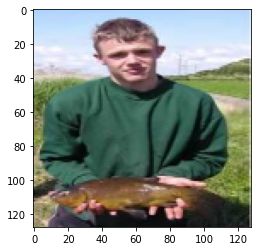

In [30]:
b0 = next(iter(val_dataloader))
ic(b0[0].sum())
denormalized_imshow(b0[0][0])

ic| b0[0].sum(): TensorImage(-919127.8750, device='cuda:0')


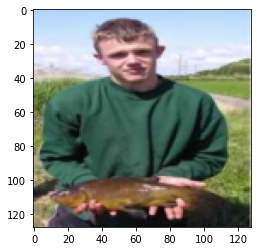

In [33]:
b0 = next(iter(dls[1]))
ic(b0[0].sum())
denormalized_imshow(b0[0][0])

In [35]:
b0 = next(iter(val_dataloader))
inputs, targets = (b0[0].to(device), b0[1].to(device))
outputs = net(inputs)
ic(outputs.sum())

def custom_accuracy(inp, targ, axis=-1):    
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    v = (pred == targ).float().mean()
    return v

learn = Learner(dls, net, metrics=custom_accuracy)
# get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False)    
net.eval()
ic(learn.validate())
ic(len(val_dataloader))

num_correct = 0
val_loss = 0.0
num_val_images = 0
net.eval()
average_accuracy = 0.0
with torch.no_grad():        
    for batch in val_dataloader:
        num_val_images += batch[0].shape[0]
        inputs, targets = (batch[0].to(device), batch[1].to(device))
        outputs = net(inputs)        
        loss = criterion(outputs, targets)
        val_loss += loss.item()
        predicted_classes = torch.argmax(outputs, dim=1)
        num_correct += torch.count_nonzero(predicted_classes == targets).item()
        average_accuracy += (predicted_classes == targets).float().mean()
    average_accuracy /= len(val_dataloader)
    val_accuracy = num_correct / len(val_dataloader.dataset)
    val_loss /= len(val_dataloader)
    ic(num_correct)
    ic(num_val_images)
    ic(len(val_dataloader.dataset))
    ic(average_accuracy)
    ic(val_accuracy)

ic| outputs.sum(): tensor(-22.8840, device='cuda:0', grad_fn=<SumBackward0>)


ic| learn.validate(): [1.0828487873077393, 0.6471337676048279]
ic| len(val_dataloader): 62
ic| num_correct: 2568
ic| num_val_images: 3925
ic| len(val_dataloader.dataset): 3925
ic| average_accuracy: tensor(0.6539, device='cuda:0')
ic| val_accuracy: 0.6542675159235669
